In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
from numba import jit, njit, prange
Sim_res = Path.cwd().parent.parent / 'MagnetCode' / "Simulation Results"
Photos_dir = Path.cwd() / 'Images'

In [2]:
@njit
def create_walk(N):
    x0 = np.array([0,0])
    steps = np.array([[1,0],[-1,0],[0,1],[0,-1]])
    walk_directions = np.random.randint(0,4, size=N)
    walk_dots = np.zeros((N, 2), dtype=np.int16)
    walk_dots[0] = x0
    for i in range(1,N):
        walk_dots[i] = walk_dots[i-1] + steps[walk_directions[i]]
    return walk_dots
    
@njit
def calc_fractions(dots, N, last_dot):
    steps = np.array([[1,0],[-1,0],[0,1],[0,-1]])
    N_new = dots.shape[0]
    walk_neighbors = 0
    neigh_fract_0 = np.zeros(4, dtype=np.float_)
    for i in range(N_new):
        walk_neighbors = 0
        for step in steps:
            potential_n = dots[i] + step
            for j in range(N_new):
                if (dots[j] == potential_n).all():
                    walk_neighbors += 1
        neigh_fract_0[walk_neighbors-1] += 1
        if (dots[i] == last_dot).all():
            atm = 4 - walk_neighbors
    neigh_fract_0 /= N_new
    return np.append(neigh_fract_0, N_new / N), atm

@jit
def experiment(N: int):
    walk = create_walk(N)    
    unique_dots = np.unique(walk, axis=0)
    return calc_fractions(unique_dots,N, walk[-1,:])
    
@jit(parallel=True)
def complex_experiment(N, di):
    n_batch = np.zeros((5,di), dtype=np.float_)
    atm = np.zeros(di, dtype=np.short)
    for i in prange(di):
        n_batch[:,i], atm[i] = experiment(N)
    return n_batch[0, :], n_batch[1,:], n_batch[2,:], n_batch[3,:], n_batch[4,:], atm
    
@njit
def stats(*args):
    n = len(args)
    means = np.zeros(n)
    stds = np.zeros(n)
    i=0
    for a in args:
        means[i], stds[i] = a.mean(), a.std()
        i+=1
    return means, stds

@njit
def atm_bins(arr):
    atms = np.array([0,0,0,0], np.int_)
    for i in range(4):
        atms[i] = (arr == i).sum()
    return atms

In [3]:
def write_results(N, obs_mean, obs_std, p, steps):
    res_array = np.array([N])
    res_array = np.append(res_array, obs_mean)
    res_array = np.append(res_array, obs_std)
    res_array = np.append(res_array, p)
    res_array = np.append(res_array, steps)
    np.savetxt('Drunk_Sailor_N_' + str(N) + '.txt', 
               [res_array], 
               delimiter=' ', 
               fmt=['%d', 
                    '%1.6f', '%1.6f', '%1.6f', '%1.6f', '%1.6f',
                    '%1.6f', '%1.6f', '%1.6f', '%1.6f', '%1.6f',
                    '%1.6f', '%1.6f', '%1.6f', '%1.6f',
                    '%d'], 
               newline=' ', 
               header='N ' + 
               ' n1_mean  n2_mean  n3_mean  n4_mean  uni_mean ' + 
               ' n1_std  n2_std  n3_std  n4_std  uni_std ' + 
               ' p0  p1  p2  p3 ' +
               ' steps\n',
               comments='')

In [12]:
def main_func(N, di, stop_i):
    n1 = np.array([])
    n2 = np.array([])
    n3 = np.array([])
    n4 = np.array([])
    nU = np.array([])
    atm = np.array([0,0,0,0], dtype=np.int_)
    means = np.array([])
    stds = np.array([])

    iters = 0
    while iters < stop_i:
        iters += 1
        n1_n, n2_n, n3_n, n4_n, nU_n, atm_n = complex_experiment(N, di)   
        n1 = np.append(n1, n1_n)
        n2 = np.append(n2, n2_n)
        n3 = np.append(n3, n3_n)
        n4 = np.append(n4, n4_n)
        nU = np.append(nU, nU_n)
        atm = atm + atm_bins(atm_n)
        obs_mean, obs_std = stats(n1,n2,n3,n4,nU)
        p_a = atm / (iters * di)
        if iters == 1:
            means = np.array([obs_mean])
            stds = np.array([obs_std])
        else:
            means = np.append(means, [obs_mean], axis=0)
            stds = np.append(stds, [obs_std], axis=0)

        write_results(N, obs_mean, obs_std, p_a, iters * di)

In [8]:
from time import time

In [13]:
%time main_func(100, 10000, 1)

CPU times: total: 7.05 s
Wall time: 7.05 s


# Обработка результатов

## История статистики

In [4]:
DIR = Sim_res / 'Geo_Rand_Walk_2D' / 'v2'
files = list(DIR.glob('*history.npz'))
files

[WindowsPath('C:/Users/Admin/Documents/Github/MagnetCode/Simulation Results/Geo_Rand_Walk_2D/v2/DS_100_history.npz'),
 WindowsPath('C:/Users/Admin/Documents/Github/MagnetCode/Simulation Results/Geo_Rand_Walk_2D/v2/DS_200_history.npz'),
 WindowsPath('C:/Users/Admin/Documents/Github/MagnetCode/Simulation Results/Geo_Rand_Walk_2D/v2/DS_500_history.npz')]

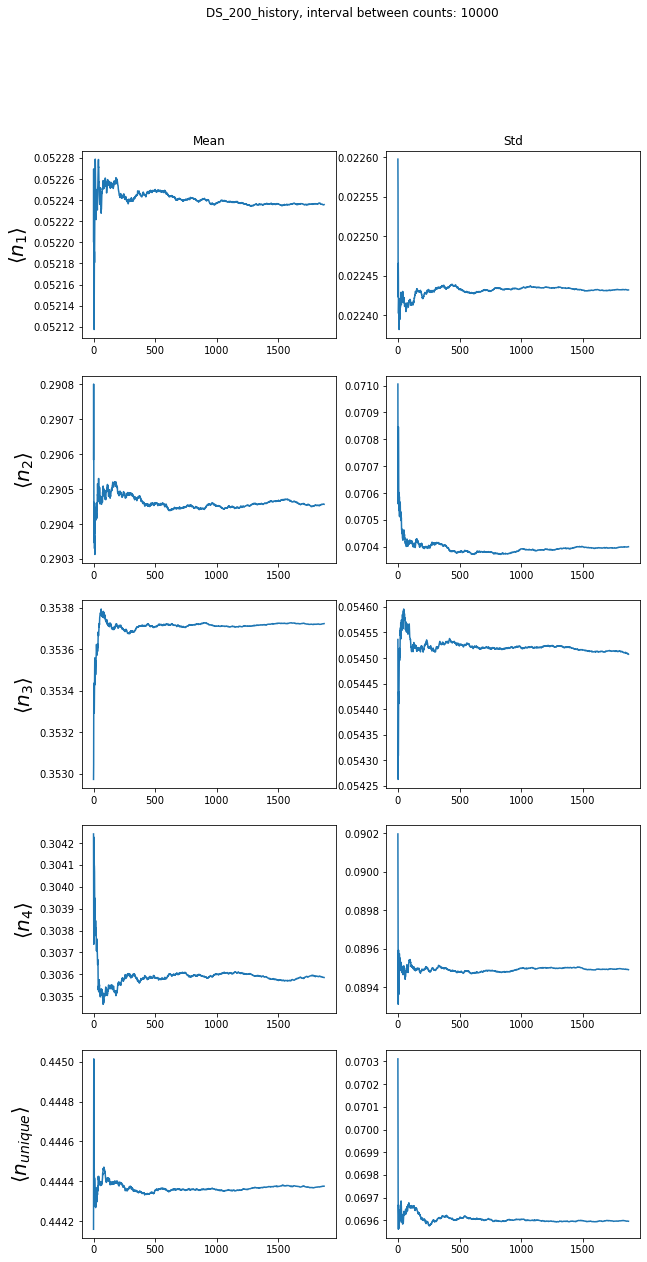

In [10]:
i=1
data = np.load(files[i])
fig, ax = plt.subplots(5, 2, figsize=(10,20))
fig.suptitle(files[i].stem + ', interval between counts: ' + str(data['iters']))
ax[0][0].set_title('Mean')
ax[0][1].set_title('Std')
names = [r'$\langle n_1 \rangle$', r'$\langle n_2 \rangle$', r'$\langle n_3 \rangle$', r'$\langle n_4 \rangle$', r'$\langle n_{unique} \rangle$'] 
for n in range(5):
    ax[n][0].set_ylabel(names[n], fontsize=20)
    ax[n][0].plot(np.repeat([np.arange(data['step'] + 1)], 5, axis=0)[n], data['means'].T[n])#, data['stds'].T[n])
    ax[n][1].plot(np.repeat([np.arange(data['step'] + 1)], 5, axis=0)[n], data['stds'].T[n])#, data['stds'].T[n])

## Вероятности атмосфер

In [3]:
DIR = Sim_res / 'Geo_Rand_Walk_2D' / 'v2_p_atmos'
if DIR.exists():
    print(*list(DIR.glob('*')), sep='\n')

C:\Users\Admin\Documents\Github\MagnetCode\Simulation Results\Geo_Rand_Walk_2D\v2_p_atmos\Drunk_Sailor_N_100.txt
C:\Users\Admin\Documents\Github\MagnetCode\Simulation Results\Geo_Rand_Walk_2D\v2_p_atmos\Drunk_Sailor_N_1000.txt
C:\Users\Admin\Documents\Github\MagnetCode\Simulation Results\Geo_Rand_Walk_2D\v2_p_atmos\Drunk_Sailor_N_10000.txt
C:\Users\Admin\Documents\Github\MagnetCode\Simulation Results\Geo_Rand_Walk_2D\v2_p_atmos\Drunk_Sailor_N_150.txt
C:\Users\Admin\Documents\Github\MagnetCode\Simulation Results\Geo_Rand_Walk_2D\v2_p_atmos\Drunk_Sailor_N_200.txt
C:\Users\Admin\Documents\Github\MagnetCode\Simulation Results\Geo_Rand_Walk_2D\v2_p_atmos\Drunk_Sailor_N_3000.txt
C:\Users\Admin\Documents\Github\MagnetCode\Simulation Results\Geo_Rand_Walk_2D\v2_p_atmos\Drunk_Sailor_N_350.txt
C:\Users\Admin\Documents\Github\MagnetCode\Simulation Results\Geo_Rand_Walk_2D\v2_p_atmos\Drunk_Sailor_N_500.txt
C:\Users\Admin\Documents\Github\MagnetCode\Simulation Results\Geo_Rand_Walk_2D\v2_p_atmos\Dr

In [5]:
files = list(DIR.glob('*0.txt'))
df = np.array([np.loadtxt(files[0], skiprows=1)])
for f in files[1:]:
    df_0 = np.loadtxt(f, skiprows=1)
    df = np.append(df, [df_0], axis=0)
df = df[np.argsort(df[:,0])]

f = open(files[1], 'r')
for line in f:
    s = line.split()
    break
    
data = pd.DataFrame(df, columns=s)
data['N'] = data['N'].apply(lambda x: int(x))
data['steps'] = data['steps'].apply(lambda x: int(x))
data

,N,n1_mean,n2_mean,n3_mean,n4_mean,uni_mean,n1_std,n2_std,n3_std,n4_std,uni_std,p0,p1,p2,p3,steps
0,100,0.067676,0.335163,0.357310,0.239851,0.490868,0.033153,0.087256,0.066923,0.092094,0.082473,0.182831,0.246855,0.290593,0.279720,96430000
1,150,0.057825,0.307880,0.356281,0.278014,0.462628,0.026306,0.076915,0.059068,0.091068,0.074602,0.212126,0.250186,0.277791,0.259897,38350000
2,200,0.052236,0.290436,0.353706,0.303622,0.444360,0.022429,0.070394,0.054511,0.089504,0.069589,0.231971,0.251413,0.269204,0.247413,36140000
3,350,0.043758,0.260707,0.345896,0.349639,0.412507,0.016683,0.059558,0.047438,0.085116,0.060991,0.268359,0.251593,0.253743,0.226305,9120000
4,500,0.039590,0.244237,0.339654,0.376519,0.394394,0.013959,0.053668,0.043809,0.081699,0.056254,0.290471,0.250914,0.244515,0.214100,7720000
5,750,0.035681,0.227604,0.331865,0.404851,0.375589,0.011504,0.047863,0.040343,0.077563,0.051463,0.313807,0.249340,0.234695,0.202158,2620000
6,1000,0.033333,0.216963,0.326096,0.423608,0.363247,0.010109,0.044158,0.038185,0.074502,0.048411,0.329962,0.247547,0.228218,0.194273,2480000
7,3000,0.026595,0.183420,0.303523,0.486462,0.322653,0.006453,0.033016,0.031532,0.062985,0.038799,0.384643,0.240439,0.205374,0.169543,230000
8,5000,0.024335,0.170867,0.293222,0.511576,0.306788,0.005359,0.029017,0.029140,0.057992,0.035158,0.409736,0.235407,0.195493,0.159364,140000
9,6500,0.023325,0.165406,0.288352,0.522917,0.299474,0.004889,0.027152,0.027979,0.055496,0.033488,0.418000,0.235480,0.191180,0.155340,50000


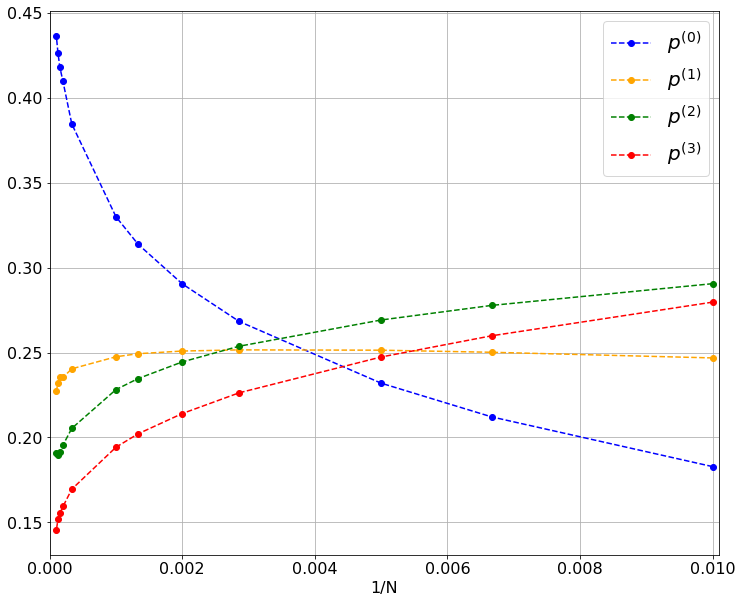

In [6]:
fig, ax = plt.subplots(figsize=(12,10))
data['1/N'] = 1/data['N']
ps = ['p0', 'p1', 'p2', 'p3']
labels = [r'$p^{(0)}$', r'$p^{(1)}$', r'$p^{(2)}$', r'$p^{(3)}$']
colors = ['blue', 'orange', 'green', 'red']
lines=[]
for p, l, c in zip(ps, labels, colors):
    lines.append(ax.plot('1/N', p, 'o--', color=c, data=data, label=l))
ax.set_xlim(0.,0.0101)
ax.set_xlabel('1/N', fontsize=16)
ax.tick_params(labelsize=16)
plt.legend(fontsize=20)
plt.grid()
#plt.savefig(Photos_dir / 'randwalk_p_atmos.png')

In [18]:
def full_scaling(x, y, dy, n, image_name=None):
    fig, axes = plt.subplots(3, 1, figsize=(13,17), constrained_layout=True)
    fig.suptitle(fr"$n_{n}$ scaling", fontsize=30)
    x_reg = x.copy()
    y_reg = y.copy()
    for i, scaling, ax in zip([0,1,2], [('linear', 'linear'), ('log', 'linear'), ('log', 'log')], axes):
        ax.errorbar(x, y, yerr=dy, fmt="s--", label=fr"MC Data of n={n}")
        ax.set_xscale(scaling[1])
        ax.set_yscale(scaling[0])
        if scaling[0] == 'linear' and scaling[1] == 'linear':
            title = 'linear scaling'
        elif scaling[0] == 'log' and scaling[1] == 'linear':
            title = 'log-linear scaling'
        else:
            title = 'log-log scaling'
        ax.set_title(title, fontsize=20)
        ax.tick_params(labelsize=16, which='both')
        ax.legend()
    axes[-1].set_xlabel('1/N', fontsize=20)
    if image_name != None:
        plt.savefig(Path.cwd() / "Images" / (image_name + ".png"))
    plt.show()